# Разработка A/B-тестирования и анализ результатов

Вы работаете продуктовым аналитиком в компании, которая разрабатывает развлекательное приложение с функцией «бесконечной» ленты, как, например, в приложениях с короткими видео. В вашем приложении существует две модели монетизации: первая — ежемесячная платная подписка, которая позволяет пользователям смотреть ленту без рекламы, вторая — демонстрация рекламы для пользователей, которые ещё не оформили подписку.

Команда разработчиков рекомендательных систем создала новый алгоритм рекомендаций, который, по их мнению, будет показывать более интересный контент для каждого пользователя. Вас, как аналитика, просят помочь рассчитать параметры A/B-теста, который позволит проверить эту гипотезу, и проанализировать его результаты.

## Описание данных

Вы будете работать с тремя таблицами:

- `sessions_project_history.csv` — таблица с историческими данными по сессиям пользователей на период с 2025-08-11 по 2025-09-23. Путь к файлу: `/datasets/sessions_project_history.csv`.

- `sessions_project_test_part.csv` — таблица с данными за первый день проведения A/B-теста, то есть за 2025-10-14. Путь к файлу: `/datasets/sessions_project_test_part.csv`.

- `sessions_project_test.csv` — таблица с данными за весь период проведения A/B-теста, то есть с 2025-10-14 по 2025-11-02. Путь к файлу: `/datasets/sessions_project_test.csv`.

У этих таблиц почти совпадает структура и содержание колонок, различаются лишь периоды наблюдения.

Поля таблиц `sessions_project_history.csv`, `sessions_project_test.csv`, `sessions_project_test_part.csv`:

- `user_id` — идентификатор пользователя;

- `session_id` — идентификатор сессии в приложении;

- `session_date` — дата сессии;

- `session_start_ts` — дата и время начала сессии;

- `install_date` — дата установки приложения;

- `session_number` — порядковый номер сессии для конкретного пользователя;

- `registration_flag` — является ли пользователь зарегистрированным;

- `page_counter` — количество просмотренных страниц во время сессии;

- `region` — регион пользователя;

- `device` — тип устройства пользователя;

- `test_group` — тестовая группа (в таблице с историческими данными этого столбца нет).


## Что нужно сделать
Ваши задачи: рассчитать параметры теста, оценить корректность его проведения и проанализировать результаты эксперимента.

### 1. Работа с историческими данными (EDA)

#### 1.1. Загрузка исторических данных
На первом этапе поработайте с историческими данными приложения:

- Импортируйте библиотеку pandas.

- Считайте и сохраните в датафрейм `sessions_history` CSV-файл с историческими данными о сессиях пользователей `sessions_project_history.csv`.

Выведите на экран первые пять строк полученного датафрейма.

In [1]:
# Импортируем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.proportion import proportions_ztest

# Выгружаем данные в переменную df
sessions_history = pd.read_csv('/datasets/sessions_project_history.csv')

# Выводим первые строки датафрейма на экран
sessions_history.head()

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [2]:
# Выводим информацию о датафрейме
sessions_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435924 entries, 0 to 435923
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   user_id            435924 non-null  object
 1   session_id         435924 non-null  object
 2   session_date       435924 non-null  object
 3   session_start_ts   435924 non-null  object
 4   install_date       435924 non-null  object
 5   session_number     435924 non-null  int64 
 6   registration_flag  435924 non-null  int64 
 7   page_counter       435924 non-null  int64 
 8   region             435924 non-null  object
 9   device             435924 non-null  object
dtypes: int64(3), object(7)
memory usage: 33.3+ MB


Видим, что пропусков в датафрейме нет

#### 1.2. Знакомство с данными
- Для каждого уникального пользователя `user_id` рассчитайте количество уникальных сессий `session_id`.

- Выведите на экран все данные из таблицы `sessions_history` для одного пользователя с наибольшим количеством сессий. Если таких пользователей несколько, выберите любого из них.

- Изучите таблицу для одного пользователя, чтобы лучше понять логику формирования каждого столбца данных.



In [3]:
unique_sessions_count = sessions_history.groupby('user_id')['session_id'].nunique()
unique_sessions_count

user_id
00005FB6A13A6FBE    2
0000B15A18D77ED9    3
0000C4E3A4A571A9    2
000293FAF9E67A81    4
00029C5AE889A6C3    2
                   ..
FFFCDE7746148710    4
FFFDD413285E753F    3
FFFECBA0F2578AB0    2
FFFEDB68228B5F21    5
FFFF4228DF580C3B    3
Name: session_id, Length: 134039, dtype: int64

In [4]:
# Нахождение пользователя с максимальным количеством сессий
user_with_max_sessions = unique_sessions_count.idxmax()

# Выборка всех данных для этого пользователя
user_data = sessions_history[sessions_history['user_id'] == user_with_max_sessions]

# Вывод данных на экран
user_data

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
115558,10E0DEFC1ABDBBE0,B8F0423BBFFCF5DC,2025-08-14,2025-08-14 13:57:39,2025-08-14,1,0,4,CIS,Android
191751,10E0DEFC1ABDBBE0,87CA2FA549473837,2025-08-15,2025-08-15 16:42:10,2025-08-14,2,0,3,CIS,Android
239370,10E0DEFC1ABDBBE0,4ADD8011DCDCE318,2025-08-16,2025-08-16 19:53:21,2025-08-14,3,0,3,CIS,Android
274629,10E0DEFC1ABDBBE0,DF0FD0E09BF1F3D7,2025-08-17,2025-08-17 15:03:43,2025-08-14,4,0,1,CIS,Android
302501,10E0DEFC1ABDBBE0,3C221774B4DE6885,2025-08-18,2025-08-18 17:29:14,2025-08-14,5,0,4,CIS,Android
325557,10E0DEFC1ABDBBE0,031BD7A67048105B,2025-08-19,2025-08-19 13:23:55,2025-08-14,6,0,2,CIS,Android
345336,10E0DEFC1ABDBBE0,FF4315CF4AD4B100,2025-08-20,2025-08-20 19:31:54,2025-08-14,7,0,2,CIS,Android
377532,10E0DEFC1ABDBBE0,4045FEA0747203B4,2025-08-22,2025-08-22 17:54:13,2025-08-14,8,0,2,CIS,Android
403538,10E0DEFC1ABDBBE0,344B086C421C7F37,2025-08-24,2025-08-24 14:46:13,2025-08-14,9,0,2,CIS,Android
414743,10E0DEFC1ABDBBE0,054F20BA371E4C9D,2025-08-25,2025-08-25 18:36:41,2025-08-14,10,0,3,CIS,Android


#### 1.3. Анализ числа регистраций
Одна из важнейших метрик продукта — число зарегистрированных пользователей. Используя исторические данные, визуализируйте, как менялось число регистраций в приложении за время его существования.

- Агрегируйте исторические данные и рассчитайте число уникальных пользователей и число зарегистрированных пользователей для каждого дня наблюдения. Для простоты считайте, что у пользователя в течение дня бывает одна сессия максимум и статус регистрации в течение одного дня не может измениться.

- Постройте линейные графики общего числа пользователей и общего числа зарегистрированных пользователей по дням. Отобразите их на одном графике.

- Постройте отдельный линейный график доли зарегистрированных пользователей от всех пользователей по дням.

- На обоих графиках должны быть заголовок, подписанные оси X и Y, сетка и легенда.

In [5]:
aggregation = sessions_history.groupby('session_date').agg({'user_id' : 'count','registration_flag' : 'sum'})
display(aggregation.head(5))

,user_id,registration_flag
session_date,,
2025-08-11,3919,169
2025-08-12,6056,336
2025-08-13,8489,464
2025-08-14,10321,625
2025-08-15,14065,840


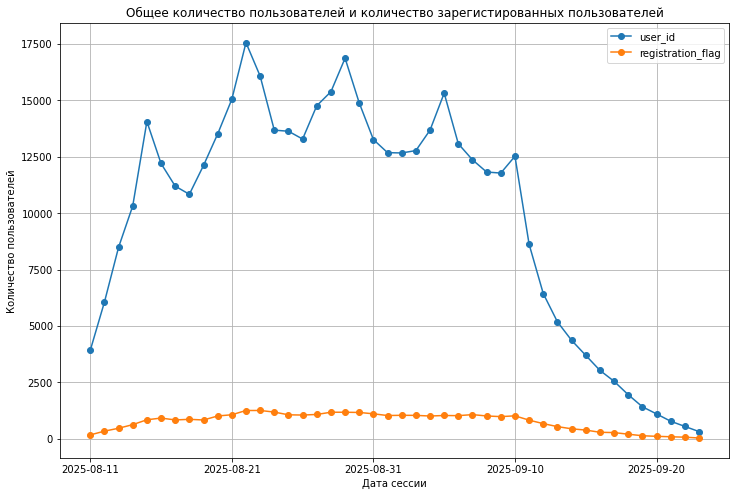

In [6]:
# Строим линейный график
aggregation.plot(
    kind= 'line',
    marker = 'o',
    figsize=(12,8)
)

plt.title('Общее количество пользователей и количество зарегистированных пользователей')
plt.ylabel('Количество пользователей')
plt.xlabel('Дата сессии')
plt.grid()


plt.show()

In [7]:
# Рассчитаем долю зарегистрированных пользователей от всех пользователей
reg_share =round(aggregation['registration_flag']/aggregation['user_id'] , 3) 
display(reg_share.head(5))

session_date
2025-08-11    0.043
2025-08-12    0.055
2025-08-13    0.055
2025-08-14    0.061
2025-08-15    0.060
dtype: float64

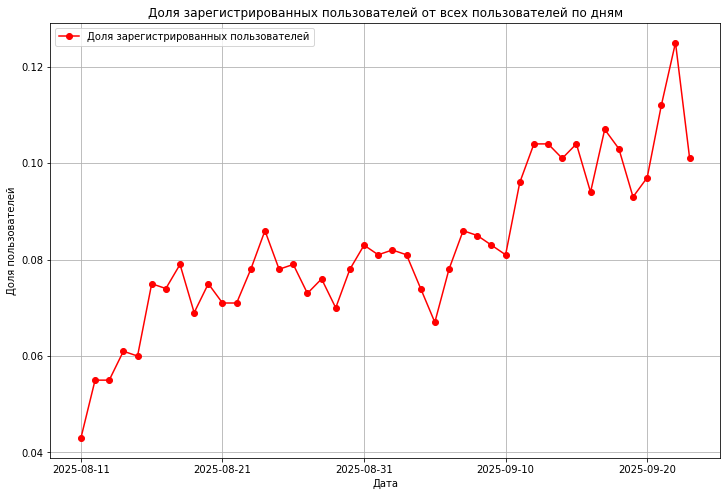

In [8]:
# Строим линейный график доли зарегистрированных пользователей от всех пользователей
diag_reg_users = reg_share.plot(
    kind = 'line',
    x = 'reg_share',
    marker = 'o',
    figsize=(12,8),
    color = 'red'
    
)
diag_reg_users.legend(['Доля зарегистрированных пользователей'])
plt.title('Доля зарегистрированных пользователей от всех пользователей по дням')
plt.ylabel('Доля пользователей')
plt.xlabel('Дата')
plt.grid()
plt.show()

Видим, что доля зарегистрированных пользовтелей по отношению к общему числу пользователей не первышает 12.5%

#### 1.4. Анализ числа просмотренных страниц
Другая важная метрика продукта — число просмотренных страниц в приложении. Чем больше страниц просмотрено, тем сильнее пользователь увлечён контентом, а значит, выше шансы, что он зарегистрируется и оплатит подписку.

- Найдите количество сессий для каждого значения количества просмотренных страниц. Например: одну страницу просмотрели в 29 160 сессиях, две страницы — в 105 536 сессиях и так далее.

- Постройте столбчатую диаграмму, где по оси X будет число просмотренных страниц, по оси Y — количество сессий.

- На диаграмме должны быть заголовок, подписанные оси X и Y.

In [9]:
# Выводим первые 5 строк датафрейма
sessions_history.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android


In [10]:
# Найдем количество сессий по количеству просмотренных страниц
pages_in_sessions = sessions_history.groupby('page_counter')['session_id'].count()
display(pages_in_sessions)

page_counter
1     29160
2    105536
3    166690
4    105569
5     26288
6      2589
7        92
Name: session_id, dtype: int64

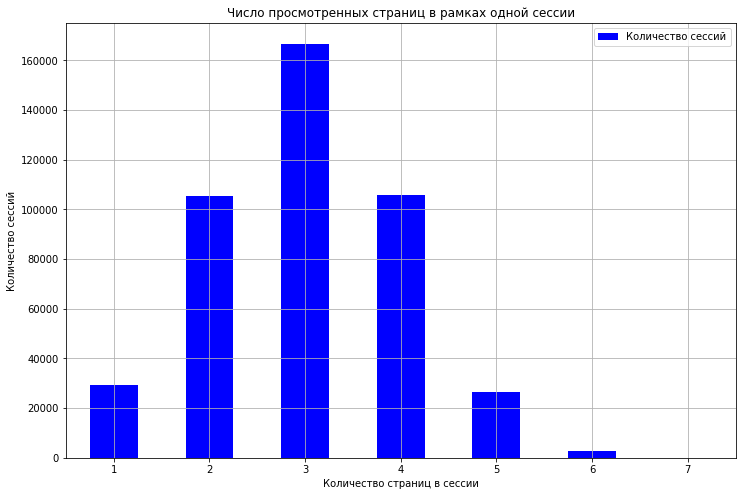

In [11]:
# Построим столбчатую диаграмму количества сессий для просмотренных страниц
diag_count_pages = pages_in_sessions.plot(kind = 'bar',
                      x = 'page_counter',
                      figsize = (12,8),
                      rot = 0,
                      color = 'blue'
                      )
plt.xlabel('Количество страниц в сессии')
plt.ylabel('Количество сессий')
diag_count_pages.legend(['Количество сессий'])
plt.grid()
plt.title('Число просмотренных страниц в рамках одной сессии')
plt.show()

Можем сделать вывод, что распределение нормальное

#### 1.5. Доля пользователей, просмотревших более четырёх страниц
Продуктовая команда продукта считает, что сессии, в рамках которых пользователь просмотрел 4 и более страниц, говорят об удовлетворённости контентом и алгоритмами рекомендаций. Этот показатель является важной прокси-метрикой для продукта.

- В датафрейме `sessions_history` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если было просмотрено меньше.

- Постройте график со средним значением доли успешных сессий от всех сессий по дням за весь период наблюдения.

In [12]:
# Добавим столбец good_session
sessions_history['good_session'] = sessions_history.apply(lambda row: 1 if row['page_counter'] >= 4 else 0, axis=1)
display(sessions_history.head(5))

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,good_session
0,E302123B7000BFE4,F9AF61A0C2023832,2025-08-15,2025-08-15 17:47:35,2025-08-15,1,0,3,CIS,iPhone,0
1,2530F72E221829FB,85003A206CBDAC6F,2025-08-15,2025-08-15 16:42:14,2025-08-15,1,0,4,MENA,Android,1
2,876E020A4FC512F5,3677423E49D72DEE,2025-08-15,2025-08-15 12:30:00,2025-08-15,1,0,4,EU,PC,1
3,2640B349E1D81584,956B45F5915CA225,2025-08-15,2025-08-15 15:31:31,2025-08-15,1,0,4,CIS,Android,1
4,94E1CBFAEF1F5EE9,83BF0DA35F9F1F40,2025-08-15,2025-08-15 21:33:53,2025-08-15,1,0,3,CIS,Android,0


In [13]:
# Сравним количество успешных сессий по отношению к общему количеству
comparison = sessions_history.groupby('session_date').agg({'session_id' : 'count','good_session' : 'sum'})
display(comparison.head(5))

,session_id,good_session
session_date,,
2025-08-11,3919,1226
2025-08-12,6056,1829
2025-08-13,8489,2604
2025-08-14,10321,3262
2025-08-15,14065,4289


In [14]:
# Посчитаем долю хороших функций для каждого дня
good_to_all = round(comparison['good_session']/comparison['session_id'] ,3) 
display(good_to_all.head(5))

session_date
2025-08-11    0.313
2025-08-12    0.302
2025-08-13    0.307
2025-08-14    0.316
2025-08-15    0.305
dtype: float64

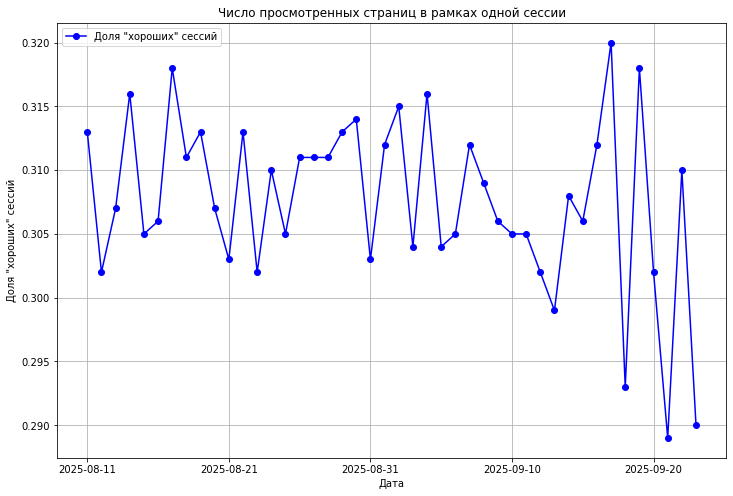

In [15]:
# Построим график с долей успешных сессий для каждого дня
diag_good_sessions = good_to_all.plot(kind = 'line',
                    x = 'session_date',
                    figsize = (12,8),
                    marker = 'o',
                    rot = 0,
                    color = 'blue'
                    )
plt.xlabel('Дата')
plt.ylabel('Доля "хороших" сессий')
diag_good_sessions.legend(['Доля "хороших" сессий'])
plt.grid()
plt.title('Число просмотренных страниц в рамках одной сессии')
plt.show()

По графику мы наблюдаем спад в конце периода

### 2. Подготовка к тесту
При планировании теста необходимо проделать несколько важных шагов:

- Сформулировать нулевую и альтернативную гипотезы

- Определиться с целевой метрикой.

- Рассчитать необходимый размер выборки.

- Исходя из текущих значений трафика рассчитать необходимую длительность проведения теста.

#### 2.1 Формулировка нулевой и альтернативной гипотез

Перед тем как проводить А/B-тест, необходимо сформулировать нулевую и альтернативную гипотезы. Напомним изначальное условие: команда разработчиков рекомендательных систем создала новый алгоритм, который, по их мнению, будет показывать более интересный контент для каждого пользователя.

О какой метрике идёт речь? Как она будет учтена в формулировке гипотез?

Сформулируйте нулевую и альтернативную гипотезы:






Чтобы оценить вовлеченность, возьмем за целевую метрику **долю хороших сессий**

Сформируем 2 гипотезы:

**H0**: доля успешных сессий в двух выборках не различается или различия не статистически значимы

**H1**: доля успешных сессий в двух выборках различается или различия статистически значимы

#### 2.2. Расчёт размера выборки
В рамках курса вы уже рассчитывали размеры выборки и  использовали для этого онлайн-калькулятор. В этом задании предлагаем воспользоваться готовым кодом и рассчитать необходимое для вашего эксперимента количество пользователей.

Для этого установите в коде ниже следующие параметры:

- Уровень значимости — 0.05.

- Вероятность ошибки второго рода — 0.2.

- Мощность теста.

- Минимальный детектируемый эффект, или MDE, — 3%. Обратите внимание, что здесь нужно указать десятичную дробь, а не процент.

При расчёте размера выборки используйте метод `solve_power()` из класса `power.NormalIndPower` модуля `statsmodels.stats`.

Запустите ячейку и изучите полученное значение.

In [16]:
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportion_effectsize

# Задаём параметры
alpha = 0.05  # Уровень значимости
beta = 0.2  # Ошибка второго рода, часто 1 - мощность
power = 0.8  # Мощность теста
p = 0.3 # Базовый уровень доли
mde = 0.03 * p  # Минимальный детектируемый эффект
effect_size = proportion_effectsize(p, p + mde)

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = effect_size,
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 41040


#### 2.3. Расчёт длительности A/B-теста

Используйте данные о количестве пользователей в каждой выборке и среднем количестве пользователей приложения. Рассчитайте длительность теста, разделив одно на другое.

- Рассчитайте среднее количество уникальных пользователей приложения в день.

- Определите длительность теста исходя из рассчитанного значения размера выборок и среднего дневного трафика приложения. Количество дней округлите в большую сторону.

In [17]:
from math import sqrt
import numpy as np

# Среднее количество пользователей приложения в день по историческим данным
avg_daily_users = round(sessions_history.groupby(by='session_date')['user_id'].nunique().mean())
display(avg_daily_users)

# Рассчитываем длительность теста в днях как отношение размера выборки к среднему числу пользователей
test_duration = np.ceil(sample_size*2/avg_daily_users)

print(f"Рассчитанная длительность A/B-теста при текущем уровне трафика в {avg_daily_users} пользователей в день составит {test_duration} дней")

9907

Рассчитанная длительность A/B-теста при текущем уровне трафика в 9907 пользователей в день составит 9.0 дней


### 3. Мониторинг А/В-теста

#### 3.1. Проверка распределения пользователей

A/B-тест успешно запущен, и уже доступны данные за первые три дня. На этом этапе нужно убедиться, что всё идёт хорошо: пользователи разделены правильным образом, а интересующие вас метрики корректно считаются.

- Считайте и сохраните в датафрейм `sessions_test_part` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test_part.csv`.

- Рассчитайте количество уникальных пользователей в каждой из экспериментальных групп для одного дня наблюдения.

- Рассчитайте и выведите на экран процентную разницу в количестве пользователей в группах A и B. Постройте любую удобную визуализацию, на которой будет видно возможное различие двух групп.

Для расчёта процентной разницы воспользуйтесь формулой:
$$P = 100 \cdot  \frac{|A − B|}{A}$$

In [18]:
# Создадим  датафрейм sessions_test_part
sessions_test_part = pd.read_csv('/datasets/sessions_project_test_part.csv')

In [19]:
# Выведем информацию о датафреме sessions_test_part
display(sessions_test_part.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3130 entries, 0 to 3129
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            3130 non-null   object
 1   session_id         3130 non-null   object
 2   session_date       3130 non-null   object
 3   session_start_ts   3130 non-null   object
 4   install_date       3130 non-null   object
 5   session_number     3130 non-null   int64 
 6   registration_flag  3130 non-null   int64 
 7   page_counter       3130 non-null   int64 
 8   region             3130 non-null   object
 9   device             3130 non-null   object
 10  test_group         3130 non-null   object
dtypes: int64(3), object(8)
memory usage: 269.1+ KB


None

In [20]:
# Выведем первые 5 строк датафрейма
sessions_test_part.head(5)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group
0,3404844B53442747,B4901323BD537E45,2025-10-14,2025-10-14 19:28:49,2025-10-14,1,0,3,CIS,Android,B
1,3A2BF4D364E62D89,216FC619308F8788,2025-10-14,2025-10-14 21:11:04,2025-10-14,1,0,3,MENA,iPhone,A
2,79CDAE11E32B1597,EDFCE4AC1A504074,2025-10-14,2025-10-14 21:44:03,2025-10-14,1,0,3,CIS,iPhone,A
3,D6AF8D78297A931F,CF0AC0EEDE92C690,2025-10-14,2025-10-14 19:07:55,2025-10-14,1,0,4,CIS,PC,A
4,37E0CE723AE568E0,2E6ED45E8C86C4E9,2025-10-14,2025-10-14 15:39:44,2025-10-14,1,0,3,CIS,Mac,B


In [21]:
# рассчитаем количество уникальных пользователей в группе A
len_a = (sessions_test_part[sessions_test_part['test_group'] == 'A']['user_id']).nunique()
display(len_a)

# рассчитаем количество уникальных пользователей в группе B
len_b = (sessions_test_part[sessions_test_part['test_group'] == 'B']['user_id']).nunique()
display(len_b)

1477

1466

In [22]:
# Рассчитаем процентную разницу размеров групп
perc_diff = round(100 * (len_a-len_b)/len_a ,2)
display(perc_diff)

0.74

Разница размеров групп 0.74% - незначительное различие

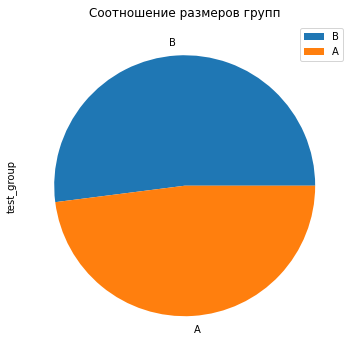

In [23]:
# Отобразим соотношение размеров групп на круговой диаграмме
diag_perc_diff = sessions_test_part['test_group'].value_counts().plot(kind = 'pie',
                                                    figsize = (8,6),
)
plt.legend()
plt.title('Соотношение размеров групп')
plt.show()

#### 3.2. Проверка пересечений пользователей
Помимо проверки равенства количества пользователей в группах, полезно убедиться в том, что группы независимы. Для этого нужно убедиться, что никто из пользователей случайно не попал в обе группы одновременно.

- Рассчитайте количество пользователей, которые встречаются одновременно в группах A и B, или убедитесь, что таких нет.

In [24]:
# Найдем пересечения списков user_id из разных групп 
gr_a = sessions_test_part[sessions_test_part['test_group'] == 'A'] # группа A
gr_b = sessions_test_part[sessions_test_part['test_group'] == 'B'] # группа B

intersection = list(set(gr_a['user_id']) & set(gr_b['user_id']))
display(intersection)

[]

Пересечений не обнаружено, нет пользователей, попавших в обе группы

#### 3.3. Равномерность разделения пользователей по устройствам
Полезно также убедиться в том, что пользователи равномерно распределены по всем доступным категориальным переменным — типам устройств и регионам.

Постройте две диаграммы:

- доля каждого типа устройства для пользователей из группы A,

- доля каждого типа устройства для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение устройств в группах A и B.


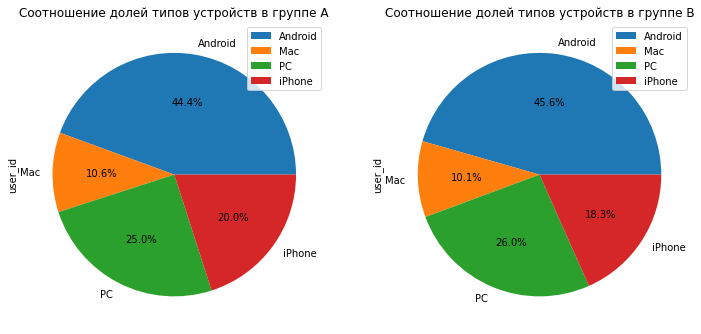

In [25]:
# Отобразим доли устройств в каждой группе тестирования
fig, axes = plt.subplots(1,2, figsize=(12, 8))

diag_device_type = gr_a.groupby('device')['user_id'].nunique().plot(kind = 'pie',
                                          legend = True,
                                          autopct='%1.1f%%',
                                          ax=axes[0]
                                                    )
axes[0].set_title('Соотношение долей типов устройств в группе A')


diag_device_type = gr_b.groupby('device')['user_id'].nunique().plot(kind = 'pie',
                                          legend = True,
                                          autopct='%1.1f%%',
                                          ax=axes[1]
                                          )
axes[1].set_title('Соотношение долей типов устройств в группе B')

plt.show()

In [26]:
# рассчитаем разницу между долями разных устройств для групп A и B (ниже результат в процентах)
round (100 * (gr_a.groupby('device')['user_id'].nunique()/len(gr_a) - gr_b.groupby('device')['user_id'].nunique()/len(gr_b)) , 2)

device
Android    2.64
Mac        1.30
PC         1.16
iPhone     3.18
Name: user_id, dtype: float64

Видим незначительные различия между долями устройств в группах тестирования.

Самое значительная разница в доле Iphone:
- В группе A доля Iphone от всех устройств на 1.7% больше, чем в группе B

Далее разница в доле Android:
- В группе A доля Android от всех устройств на 1.2% больше, чем в группе B

#### 3.4. Равномерность распределения пользователей по регионам
Теперь убедитесь, что пользователи равномерно распределены по регионам.

Постройте две диаграммы:

- доля каждого региона для пользователей из группы A,

- доля каждого региона для пользователей из группы B.

Постарайтесь добавить на диаграммы все необходимые подписи, пояснения и заголовки, которые позволят сделать вывод о том, совпадает ли распределение регионов в группах A и B. Постарайтесь использовать другой тип диаграммы, не тот, что в прошлом задании.


In [27]:
sessions_test_part.groupby(['test_group','region'])['user_id'].nunique()

test_group  region
A           CIS       644
            EU        224
            MENA      609
B           CIS       645
            EU        217
            MENA      604
Name: user_id, dtype: int64

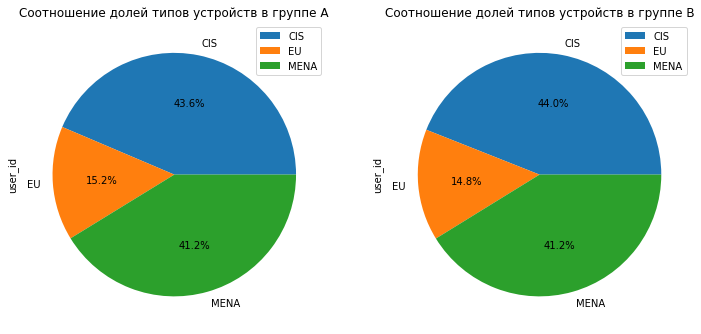

In [28]:
# Отобразим доли пользователей по регионам в каждой группе тестирования

fig, axes = plt.subplots(1,2, figsize=(12, 8))

diag_region_a = gr_a.groupby('region')['user_id'].nunique().plot(kind = 'pie',
                                          legend = True,
                                          autopct='%1.1f%%',
                                          ax=axes[0])
axes[0].set_title('Соотношение долей типов устройств в группе A')


diag_region_b = gr_b.groupby('region')['user_id'].nunique().plot(kind = 'pie',
                                          legend = True,
                                          autopct='%1.1f%%',
                                          ax=axes[1]
                                          )

axes[1].set_title('Соотношение долей типов устройств в группе B')

plt.show()

Видим, что во всех регионах значения в группах А и группах практически одинаковые, различия незначительны, они около 0.4%

#### 3.5. Вывод после проверки A/B-теста

На основе проведённого анализа A/B-теста сформулируйте и запишите свои выводы. В выводе обязательно укажите:

- Было ли обнаружено различие в количестве пользователей в двух группах.

- Являются ли выборки независимыми. Было ли обнаружено пересечение пользователей из тестовой и контрольной групп.

- Сохраняется ли равномерное распределение пользователей тестовой и контрольной групп по категориальным переменным: устройствам и регионам.

Сделайте заключение: корректно ли проходит A/B-тест, или наблюдаются какие-либо нарушения.

**Вывод после проверки**

Пользователи были разделены на 2 группы:
1477 и 1466 человек - сопоставимые размеры; группа A на 0.74% меньше группы B, такую разницу считаем незначительной.
Проверили пересечение групп - пересечений нет, каждый пользователь попал только в 1 группу.

Распределение пользователей разных групп по устройствам и регионам равномерно. Различия по категориям устройств в пределах 1.7%, по регионам - не более 0.4%.

Таким образом, на данный момент A/B-тест проходит корректно, нарушения не выявлены.

### 4. Проверка результатов A/B-теста

A/B-тест завершён, и у вас есть результаты за все дни проведения эксперимента. Необходимо убедиться в корректности теста и верно интерпретировать результаты.

#### 4.1. Получение результатов теста и подсчёт основной метрики

- Считайте и сохраните в датафрейм `sessions_test` CSV-файл с историческими данными о сессиях пользователей `sessions_project_test.csv`.

- В датафрейме `sessions_test` создайте дополнительный столбец `good_session`. В него войдёт значение `1`, если за одну сессию было просмотрено 4 и более страниц, и значение `0`, если просмотрено меньше.

In [29]:
# Создадим датафрейм sessions_test 
sessions_test = pd.read_csv('/datasets/sessions_project_test.csv')

# Добавим столбец good_session и выведем первые строки датафрейма
sessions_test['good_session'] = sessions_test.apply(lambda row: 1 if row['page_counter'] >= 4 else 0, axis=1)
display(sessions_test.head())

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0
3,43D7585009168086,5763C0C353C22263,2025-10-24,2025-10-24 15:01:57,2025-10-18,4,0,1,CIS,iPhone,B,0
4,15AD68B14D62D88C,B1AD09F93C1053BC,2025-10-17,2025-10-17 17:34:39,2025-10-17,1,0,2,MENA,Android,B,0


#### 4.2. Проверка корректности результатов теста

Прежде чем приступать к анализу ключевых продуктовых метрик, необходимо убедиться, что тест проведён корректно и вы будете сравнивать две сопоставимые группы.

- Рассчитайте количество уникальных сессий для каждого дня и обеих тестовых групп, используя группировку.

- Проверьте, что количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимыми. Используйте статистический тест, который позволит сделать вывод о равенстве средних двух выборок.

- В качестве ответа выведите на экран полученное значение p-value и интерпретируйте его.

In [30]:
# рассчитаем количество уникальных сессий для каждой группы, для каждого дня
unique_sessions = sessions_test.groupby(['test_group','session_date'])['session_id'].nunique()

display(unique_sessions)

test_group  session_date
A           2025-10-14      1502
            2025-10-15      2235
            2025-10-16      3280
            2025-10-17      4089
            2025-10-18      5013
            2025-10-19      6535
            2025-10-20      5837
            2025-10-21      3927
            2025-10-22      3083
            2025-10-23      2470
            2025-10-24      2090
            2025-10-25      1897
            2025-10-26      1669
            2025-10-27      1454
            2025-10-28      1279
            2025-10-29      1068
            2025-10-30       887
            2025-10-31       644
            2025-11-01       434
            2025-11-02       158
B           2025-10-14      1628
            2025-10-15      2283
            2025-10-16      3241
            2025-10-17      4054
            2025-10-18      5059
            2025-10-19      6779
            2025-10-20      6089
            2025-10-21      3981
            2025-10-22      3111
            2025-1

In [31]:
# Зададим уровень значимости
alpha = 0.05

unique_sessions_1 = unique_sessions.loc['A']
unique_sessions_2 = unique_sessions.loc['B']


stat_ttest, p_value_ttest = ttest_ind(
    unique_sessions_1, 
    unique_sessions_2, 
    alternative='two-sided' ## поскольку альтернативная гипотеза о том, что выборочное среднее первой выборки(metric_a) меньше второй выборки
)

if p_value_ttest>alpha:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны')
    print('Количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы')
else:
    print(f'p-value теста Стьюдента ={round(p_value_ttest, 2)}')
    print('Нулевая гипотеза не находит подтверждения! Выборочные средние в группах A и B не равны, и в группе B больше')
    print('Количество уникальных дневных сессий в двух выборках  различается или различия статистически значимы')


p-value теста Стьюдента =0.94
Нулевая гипотеза находит подтверждение! Выборочные средние в группах A и B равны
Количество уникальных дневных сессий в двух выборках не различается или различия не статистически значимы


#### 4.3. Сравнение доли успешных сессий

Когда вы убедились, что количество сессий в обеих выборках не различалось, можно переходить к анализу ключевой метрики — доли успешных сессий.

Используйте созданный на первом шаге задания столбец `good_session` и рассчитайте долю успешных сессий для выборок A и B, а также разницу в этом показателе. Полученный вывод отобразите на экране.

In [32]:
sessions_test.head(3)

,user_id,session_id,session_date,session_start_ts,install_date,session_number,registration_flag,page_counter,region,device,test_group,good_session
0,6DAE3B3654DA738E,C69249E26E58F6E2,2025-10-26,2025-10-26 18:15:05,2025-10-16,3,0,3,MENA,Android,A,0
1,0A3FE5D1DD59110A,66D66D7C9F5181B7,2025-10-21,2025-10-21 17:04:53,2025-10-15,2,1,2,CIS,Android,B,0
2,2041F1D7AA740B88,50DE51D42215E74C,2025-10-23,2025-10-23 17:39:29,2025-10-19,3,0,2,MENA,Android,A,0


In [33]:
group_a = sessions_test[sessions_test['test_group'] == 'A'] # группа A
group_b = sessions_test[sessions_test['test_group'] == 'B'] # группа B

# рассчитаем доли успешных сессий в каждой группе
good_share_a = group_a['good_session'].sum()/group_a['session_id'].nunique()
good_share_b = group_b['good_session'].sum()/group_b['session_id'].nunique()
diff = round((100 *( good_share_a - good_share_b )),1 )
print(f'''Доля успешных сессий в группе A: {good_share_a}
Доля "хороших" сессий в группе B: {good_share_b}
Разница долей успешных сессий: {diff}%''')

Доля успешных сессий в группе A: 0.3077233557344958
Доля "хороших" сессий в группе B: 0.31828992745867524
Разница долей успешных сессий: -1.1%


#### 4.4. Насколько статистически значимо изменение ключевой метрики

На предыдущем шаге вы убедились, что количество успешных сессий в тестовой выборке примерно на 1.1% выше, чем в контрольной, но делать выводы только на основе этого значения будет некорректно. Для принятия решения всегда необходимо отвечать на вопрос: является ли это изменение статистически значимым.

- Используя статистический тест, рассчитайте, является ли изменение в метрике доли успешных сессий статистически значимым.

- Выведите на экран полученное значение p-value и свои выводы о статистической значимости. Напомним, что уровень значимости в эксперименте был выбран на уровне 0.05.

In [34]:
# Количество "успехов" 
m_a = group_a['good_session'].sum()
m_b = group_b['good_session'].sum()

# Размеры выборок
n_a = group_a['session_id'].nunique()
n_b = group_b['session_id'].nunique()

# определим уровень значимости
alpha = 0.05


stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' # так как H_1: p_a < p_b
)

stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative = 'two-sided')

display(p_value_ztest)

if p_value_ztest > alpha:
    print('Нулевая гипотеза находит подтверждение!')
else:
    print('Нулевая гипотеза не находит подтверждения!')

0.0003149479976072246

Нулевая гипотеза не находит подтверждения!


Так как p_value z-теста меньше alpha, альтернативная гипотеза находит подтверждение.

То есть изменение количества успешных сессий в тестовой группе является статитически значимым.

#### 4.5. Вывод по результатам A/B-эксперимента

На основе проведённого анализа результатов теста сформулируйте и запишите свои выводы для команды разработки приложения. В выводе обязательно укажите:

- Характеристики проведённого эксперимента, количество задействованных пользователей и длительность эксперимента.

- Повлияло ли внедрение нового алгоритма рекомендаций на рост ключевой метрики и как.

- Каким получилось значение p-value для оценки статистической значимости выявленного эффекта.

- Стоит ли внедрять нововведение в приложение.

При проведении A/B тестирования были использованы данные 41040 уникальных пользователей, использовавших приложение в течение 9 дней.

Внедрение нового алгоритма увеличило количество успешных сессий на 1.1%.

Выяснили также, что p_value z-теста меньше уровня значимости, то есть увелиечение количества успешных сессий можно считать статистически значимым.

Таким образом, стоит внедрить новоовведение в приложение.